In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/_x/rnsqmrxd52ld0jrwjdynyn240000gn/T/ipykernel_70486/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

# Import necessary functions from SQLAlchemy
from sqlalchemy import func

# Query the most recent date in the dataset
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Print the most recent date
print(f"{most_recent_date}")


2017-08-23


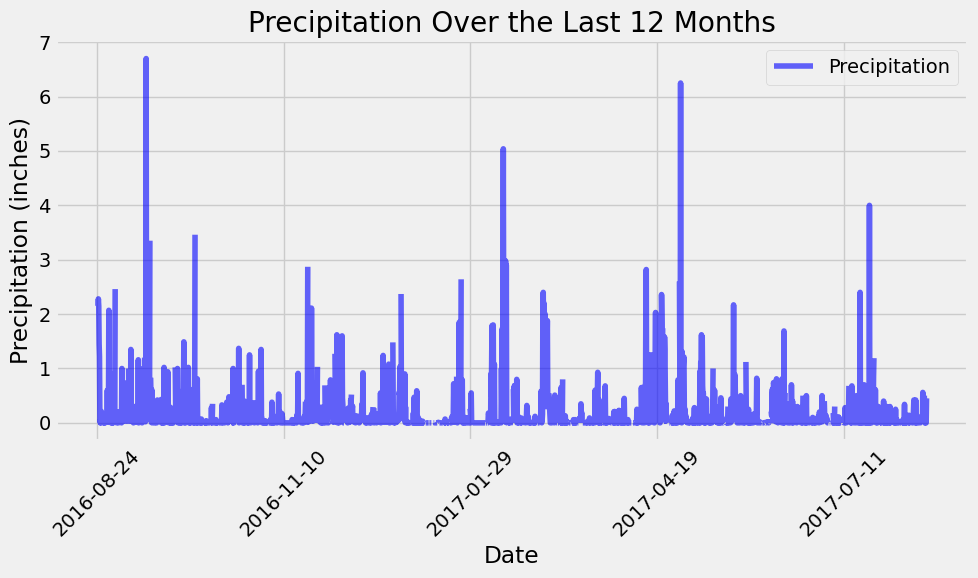

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in the dataset
last_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame with column names "Date" and "Precipitation"
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Set the date as the index for plotting
precipitation_df.set_index('Date', inplace=True)

# Plot the data using Pandas' plotting function
precipitation_df.plot(figsize=(10, 6), title="Precipitation Over the Last 12 Months", color='blue', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()

# Display the summary statistics as a table
precipitation_summary_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset

# Import necessary function from SQLAlchemy
from sqlalchemy import func

# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

# Display the result
print(f"{total_stations}")

9


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Import necessary functions from SQLAlchemy
from sqlalchemy import func

# Design a query to find the most active stations
active_stations = session.query(
    measurement.station, 
    func.count(measurement.station).label('station_count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

# Display the results
for station, count in active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Assuming 'active_stations' from the previous query is available

# Get the station ID of the most active station
most_active_station = active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs), 
    func.max(measurement.tobs), 
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station).all()

# Extract the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]

# Display the results
print(f"Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp:.2f}°F")

Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


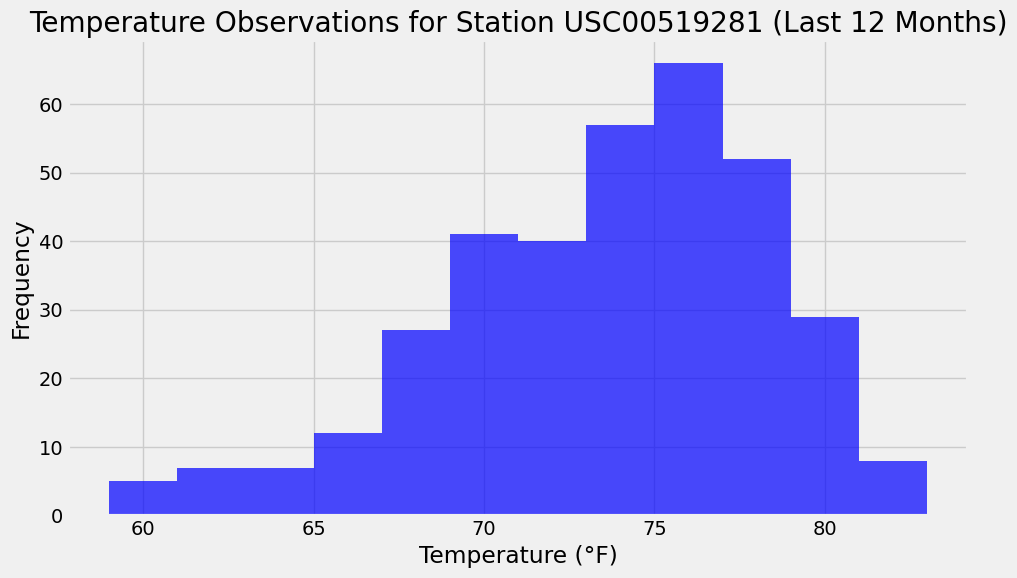

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year ago from the most recent date in the dataset
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
tobs_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago).all()

# Convert the query results to a list (unpack the tuples)
tobs_list = [temp[0] for temp in tobs_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(tobs_list, bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# Close Session

In [22]:
# Close Session
session.close()